In [1]:
import warnings
from collections import namedtuple
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
torch.set_num_threads(2)
import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.utils import save_image
import params
from ipylab import JupyterFrontEnd

import argparse
import time
import sys
import torch
import torch.nn.functional as F
import torch.optim as optim

from meta_ood.meta_ood_master.config import config_training_setup
from meta_ood.meta_ood_master.src.imageaugmentations import Compose, Normalize, ToTensor, RandomCrop, RandomHorizontalFlip
from meta_ood.meta_ood_master.src.model_utils import load_network
from meta_ood.meta_ood_master.UNet import ResNetUNet, convrelu
from torch.utils.data import DataLoader

app = JupyterFrontEnd()
app.commands.execute('notebook:render-all-markdown')

In [2]:
Label = namedtuple( 'Label' , [
    'name' ,    # The identifier of this label. We use them to uniquely name a class
    'id' ,      # An integer ID that is associated with this label. The IDs are used to represent the label in ground truth images. 
                # An ID of -1 means that this label does not have an ID and thus is ignored when creating ground truth images (e.g. license plate).
    'trainId' , # Create ground truth images with train IDs. For trainIds, multiple labels might have the same ID. 
                # Then, these labels are mapped to the same class in the ground truth images.
                # For the inverse mapping, we use the label that is defined first in the list below.
                # For example, mapping all void-type classes to the same ID in training might make sense for some approaches. Max value is 255!
    'category' ,    # The name of the category that this label belongs to
    'categoryId' ,  # The ID of this category. Used to create ground truth images on category level.
    'hasInstances', # Whether this label distinguishes between single instances or not
    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored during evaluations or not
    'color' ,       # The color of this label
])

class ClassDefinitions(object):
    def __init__(self, classlabels):
        self.labels=classlabels
        for i, label in zip(range(len(self.labels)),self.labels):
            if isinstance(label.color, int):
                self.labels[i]=label._replace(color=tuple([int(label.color/(256.0**2))%256, int(label.color%256.0)%256, int(label.color)%256]))
    def getlabels(self):
        return self.labels
    def getname2label(self):
        name2label={label.name:label for label in self.labels}
        return name2label
    def getid2label(self):
        id2label={label.id:label for label in self.labels}
        return id2label
    def gettrainid2label(self):
        trainid2label={label.trainId: label for label in reversed(self.labels)}
        return trainid2label
    def category2label(self):
        category2labels={}
        for label in self.labels:
            category=label.category
            if category in category2labels:
                category2labels[category].append(label)
            else:
                category2labels[category]=[label]
    def assureSingleInstanceName(self, name):
        name2label=self.getname2label()
        if name in name2label:
            return name
        if not name.endswith("group"):
            return None
        name=name[:-len("group")]
        if not name in name2label:
            return None
        if not name2label[name].hasInstances:
            return None
        return name

labels_cityscapes = ClassDefinitions([
    #       name                    id trainId category    catId hasInstances ignoreInEval color
    Label( 'unlabeled' ,            0 ,  255 , 'void' ,         0 , False , True ,  ( 0, 0, 0) ),
    Label( 'ego vehicle' ,          1 ,  255 , 'void' ,         0 , False , True ,  ( 0, 0, 0) ),
    Label( 'rectification border' , 2 ,  255 , 'void' ,         0 , False , True ,  ( 0, 0, 0) ),
    Label( 'out of roi' ,           3 ,  255 , 'void' ,         0 , False , True ,  ( 0, 0, 0) ),
    Label( 'static' ,               4 ,  255 , 'void' ,         0 , False , True ,  ( 0, 0, 0) ),
    Label( 'dynamic' ,              5 ,  255 , 'void' ,         0 , False , True ,  ( 111, 74, 0) ),
    Label( 'ground' ,               6 ,  255 , 'void' ,         0 , False , True ,  ( 81, 0, 81) ),
    Label( 'road' ,                 7 ,  0 ,   'flat' ,         1 , False , False , (128, 64,128) ),
    Label( 'sidewalk' ,             8 ,  1 ,   'flat' ,         1 , False , False , (244, 35,232) ),
    Label( 'parking' ,              9 ,  255 , 'flat' ,         1 , False , True ,  (250,170,160) ),
    Label( 'rail track' ,           10 , 255 , 'flat' ,         1 , False , True ,  (230,150,140) ),
    Label( 'building' ,             11 , 2 ,   'construction' , 2 , False , False , ( 70, 70, 70) ),
    Label( 'wall' ,                 12 , 3 ,   'construction' , 2 , False , False , (102,102,156) ),
    Label( 'fence' ,                13 , 4 ,   'construction' , 2 , False , False , (190,153,153) ),
    Label( 'guard rail' ,           14 , 255 , 'construction' , 2 , False , True ,  (180,165,180) ),
    Label( 'bridge' ,               15 , 255 , 'construction' , 2 , False , True ,  (150,100,100) ),
    Label( 'tunnel' ,               16 , 255 , 'construction' , 2 , False , True ,  (150,120, 90) ),
    Label( 'pole' ,                 17 , 5 ,   'object' ,       3 , False , False , (153,153,153) ),
    Label( 'polegroup' ,            18 , 255 , 'object' ,       3 , False , True ,  (153,153,153) ),
    Label( 'traffic light' ,        19 , 6 ,   'object' ,       3 , False , False , (250,170, 30) ),
    Label( 'traffic sign' ,         20 , 7 ,   'object' ,       3 , False , False , (220,220, 0) ),
    Label( 'vegetation' ,           21 , 8 ,   'nature' ,       4 , False , False , (107,142, 35) ),
    Label( 'terrain' ,              22 , 9 ,   'nature' ,       4 , False , False , (152,251,152) ),
    Label( 'sky' ,                  23 , 10 ,  'sky' ,          5 , False , False , ( 70,130,180) ),
    Label( 'person' ,               24 , 11 ,  'human' ,        6 , True ,  False ,  (220, 20, 60) ),
    Label( 'rider' ,                25 , 12 ,  'human' ,        6 , True ,  False ,  (255, 0, 0) ),
    Label( 'car' ,                  26 , 13 ,  'vehicle' ,      7 , True ,  False ,  ( 0, 0,142) ),
    Label( 'truck' ,                27 , 14 ,  'vehicle' ,      7 , True ,  False ,  ( 0, 0, 70) ),
    Label( 'bus' ,                  28 , 15 ,  'vehicle' ,      7 , True ,  False ,  ( 0, 60,100) ),
    Label( 'caravan' ,              29 , 255 , 'vehicle' ,      7 , True ,  True ,   ( 0, 0, 90) ),
    Label( 'trailer' ,              30 , 255 , 'vehicle' ,      7 , True ,  True ,   ( 0, 0,110) ),
    Label( 'train' ,                31 , 16 ,  'vehicle' ,      7 , True ,  False ,  ( 0, 80,100) ),
    Label( 'motorcycle' ,           32 , 17 ,  'vehicle' ,      7 , True ,  False ,  ( 0, 0,230) ),
    Label( 'bicycle' ,              33 , 18 ,  'vehicle' ,      7 , True ,  False ,  (119, 11, 32) ),
    Label( 'license plate' ,        -1 , 255 , 'vehicle' ,      7 , False , True ,  ( 0, 0,142) ),
])

def convert_id_to_trainid(sem):
    id2label=labels_cityscapes.getid2label()
    new_sem=sem.clone()
    for label_id in id2label:
        train_id=id2label[label_id].trainId
        new_sem[sem==label_id]=train_id
    return new_sem

def convert_id_to_color(sem):
    sem=sem.to(torch.uint8)
    id2label=labels_cityscapes.getid2label()
    new_sem=torch.zeros((sem.shape[0], sem.shape[1], 3), dtype=torch.uint8)
    for label_id in id2label:
        color=id2label[label_id].color
        new_sem[sem==label_id,:]=torch.tensor(color,dtype=torch.uint8).view(1,3)
    newsem=new_sem.to(torch.uint8)
    return new_sem

def convert_trainid_to_color(sem):
    trainid2label=labels_cityscapes.gettrainid2label()
    new_sem=torch.zeros((sem.shape[0], sem.shape[1],3),dtype=torch.uint8)
    for train_id in trainid2label:
        color=trainid2label[train_id].color
        new_sem[sem==train_id,:]=torch.tensor(color,dtype=torch.uint8).view(1,3)
    newsem=new_sem.to(torch.uint8)
    return new_sem

def plot_img_sem(img,smnt,from_trainid=False, save=False, name='default',index=0):
    save_path='segmented_pictures/'+name
    fig,ax=plt.subplots(1,2,figsize=(10,20))
    if from_trainid:
        ax[0].imshow(convert_trainid_to_color(smnt).numpy())
    else:
        ax[0].imshow(convert_id_to_color(smnt).numpy())
    ax[1].imshow(np.clip(np.transpose(img.numpy(),(1,2,0))*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406]),0,1))
    plt.show()
    
    if save:
        fig_save, ax_save = plt.subplots(figsize=(5, 10))
        ax_save.imshow(ax[index].images[0].get_array())
        ax_save.axis('off')
        fig_save.savefig(save_path, bbox_inches='tight')
        plt.close(fig_save)  # Close the temporary figure to avoid displaying it

    

In [3]:
# #zum checken der training routine

# import argparse
# import time
# import sys
# import torch
# import torch.nn.functional as F
# import torch.optim as optim


# # %run meta_ood/meta_ood_master/config
# from meta_ood.meta_ood_master.config import config_training_setup
# from meta_ood.meta_ood_master.src.imageaugmentations import Compose, Normalize, ToTensor, RandomCrop, RandomHorizontalFlip
# from meta_ood.meta_ood_master.src.model_utils import load_network
# from torch.utils.data import DataLoader

# args={"TRAINSET": "Cityscapes+COCO",
#       "MODEL": "DeepLabV3+_WideResNet38",
#       "training_starting_epoch": 0,
#       "num_training_epochs": 1,
#       "pareto_alpha": 0.9,
#       "learning_rate": 1e-5,
#       "crop_size": 480}


# def encode_target(target, pareto_alpha, num_classes, ignore_train_ind, ood_ind=254):
    
#     print("\n")
#     print("1. We get the target:\ntarget.shape = " + str(target.shape))
#     print("type(target) = " + str(type(target)))
#     print("\n")
    
#     npy = target.numpy()
#     npz = npy.copy()
#     ############################################
#     num_classes=3
#     custom_values = [
#     [
#         [0, 0],
#         [0,254]
#         ]
#     ]
#     npy = np.array(custom_values, dtype=np.int64)
#     npz = npy.copy()
#     print("2. We turn it inot a numpy array:\nnpy.shape = " + str(npy.shape))
#     print("type(npy) = " + str(type(npy)))
#     print("npy = ")
#     print(npy)
#     print("\n")
    
#     print("4. We determine the ood-ind: "+str(ood_ind))
#     print("We replace the OoD-ID's with num_classes = {}".format(num_classes))
#     npy[np.isin(npy, ood_ind)] = num_classes
#     print(npy)
#     print("\n")
    
#     print("5. We determine the ignore_train_ind: {}".format(ignore_train_ind))
#     print("We replace the ignore_train_ind with num_classes+1 = {}".format(num_classes+1))
#     npy[np.isin(npy, ignore_train_ind)] = num_classes + 1
#     print("npy = ")
#     print(str(npy)+"\n")
    
#     print("""6. We one hot encode and cut off the columns for 19 and 20, i.e we construct an identity matrix 
#     and sort the rows according to the specifc entries in npy:""")
#     enc = np.eye(num_classes + 2)[npy][..., :-2]  # one hot encoding with last 2 axis cutoff
#     print("enc = \n{}".format(enc))
#     print("enc.shape = " + str(enc.shape))
#     print("\n")
    
#     print("7. We fill up the OoD-rows with alpha/n = {}".format(pareto_alpha / num_classes))
#     enc[(npy == num_classes)] = np.full(num_classes, round(pareto_alpha / num_classes,2))  # set all hot encoded vector
#     print("enc = \n{}".format(enc))
#     print("enc.shape = " + str(enc.shape))
#     print("\n")
    
#     print("8. Every correct class entry is filled up with 1-pareto_alpha = {}".format(0.1))
#     enc[(enc == 1)] = 1 - pareto_alpha  # convex combination between in and out distribution samples
#     print("enc = \n{}".format(enc))
#     print("enc.shape = " + str(enc.shape))
#     print("\n")
    
#     print("9. The ignored classes in ignore_train_ind = {} are set to zero according to the following boolean mask: ".format(ignore_train_ind)) 
#     enc[np.isin(npz, ignore_train_ind)] = np.zeros(num_classes)
#     print("{}".format(np.isin(npz, ignore_train_ind)))
#     print("enc = \n{}".format(enc))
#     print("enc.shape = " + str(enc.shape))
#     print("\n")
    
#     print("10. Transform back into a tensor and permute the shape: ")
#     enc = torch.from_numpy(enc)
#     enc = enc.permute(0, 3, 1, 2).contiguous()
#     print("enc.shape = " + str(enc.shape))
#     print("\n")
#     return enc

# config = config_training_setup(args)
# dataset = config.dataset()
# roots = config.roots
# params = config.params
# transform = Compose([RandomHorizontalFlip(), RandomCrop(params.crop_size), ToTensor(),
#                          Normalize(dataset.mean, dataset.std)])

# trainloader = config.dataset('train', transform, roots.cs_root, roots.coco_root, params.ood_subsampling_factor)
# dataloader = DataLoader(trainloader, batch_size=1, shuffle=True)#params.batch_size
# i=0
# for x, target in dataloader:
    
    
#     #####################################
#     # custom_values = [
#     # [
#     #     [1, 2, 3],
#     #     [4, 5, 6],
#     #     [7, 8 ,9]
#     #     ]
#     # ]
#     # target = np.array(custom_values, dtype=np.int64)
#     ###########################################################
    
#     unique_values = torch.unique(target).tolist()
#     print("Unique values in the Target Tensor: {}".format(unique_values))

#     trainid2label=labels_cityscapes.gettrainid2label()
#     for train_id in trainid2label:
#         if train_id in unique_values:
#             print(trainid2label[train_id].name)
    
#     y = encode_target(target=target, pareto_alpha=params.pareto_alpha, num_classes=dataset.num_classes,
#                       ignore_train_ind=dataset.void_ind, ood_ind=dataset.train_id_out)
#     # print(y.shape)
#     i=i+1
#     plot_img_sem(x.squeeze(0),target.squeeze(0),from_trainid=True)
#     if i>=1:
#         break;

        


In [4]:
#TODO: SOMEHOW THE BOX BELOW HAS TO BEEXECUTED FIRST ONLY THEN THIS ONE WORK

##OoD-Training
##The imports are already at the top cell

# import argparse
# import time
# import os

# import numpy as np
# import torch
# import torch.nn.functional as F
# import torch.optim as optim

# from config import config_training_setup
# from src.imageaugmentations import Compose, Normalize, ToTensor, RandomCrop, RandomHorizontalFlip
# from src.model_utils import load_network
# from torch.utils.data import DataLoader


def cross_entropy(logits, targets):
    """
    cross entropy loss with one/all hot encoded targets -> logits.size()=targets.size()
    :param logits: torch tensor with logits obtained from network forward pass
    :param targets: torch tensor one/all hot encoded
    :return: computed loss
    """
    neg_log_like = - 1.0 * F.log_softmax(logits, 1)
    L = torch.mul(targets.float(), neg_log_like)
    L = L.mean()
    return L


def encode_target(target, pareto_alpha, num_classes, ignore_train_ind, ood_ind=254):
    """
    encode target tensor with all hot encoding for OoD samples
    :param target: torch tensor
    :param pareto_alpha: OoD loss weight
    :param num_classes: number of classes in original task
    :param ignore_train_ind: void class in original task
    :param ood_ind: class label corresponding to OoD class
    :return: one/all hot encoded torch tensor
    """
    npy = target.numpy()
    npz = npy.copy()
    npy[np.isin(npy, ood_ind)] = num_classes
    npy[np.isin(npy, ignore_train_ind)] = num_classes + 1
    enc = np.eye(num_classes + 2)[npy][..., :-2]  # one hot encoding with last 2 axis cutoff
    enc[(npy == num_classes)] = np.full(num_classes, pareto_alpha / num_classes)  # set all hot encoded vector
    enc[(enc == 1)] = 1 - pareto_alpha  # convex combination between in and out distribution samples
    enc[np.isin(npz, ignore_train_ind)] = np.zeros(num_classes)
    enc = torch.from_numpy(enc)
    enc = enc.permute(0, 3, 1, 2).contiguous()
    return enc



def training_routine(config):
    """Start OoD Training"""
    print("START OOD TRAINING")
    params = config.params
    roots = config.roots
    dataset = config.dataset()
    print("Pareto alpha:", params.pareto_alpha)
    start_epoch = params.training_starting_epoch
    epochs = params.num_training_epochs
    start = time.time()

    """Initialize model"""
    if start_epoch == 0:
        network = load_network(model_name=roots.model_name, num_classes=dataset.num_classes,
                               ckpt_path=roots.init_ckpt, train=True)
        network = network.to(device)
    else:
        basename = roots.model_name + "_epoch_" + str(start_epoch) \
                   + "_alpha_" + str(params.pareto_alpha) + ".pth"
        network = load_network(model_name=roots.model_name, num_classes=dataset.num_classes,
                               ckpt_path=os.path.join(roots.weights_dir, basename), train=True)
        print(roots.model_name)

    transform = Compose([RandomHorizontalFlip(), ToTensor(),
                         Normalize(dataset.mean, dataset.std)])#, RandomCrop(params.crop_size)

    for epoch in range(start_epoch, start_epoch + epochs):
        """Perform one epoch of training"""
        print('\nEpoch {}/{}'.format(epoch + 1, start_epoch + epochs))
        optimizer = optim.Adam(network.parameters(), lr=params.learning_rate)
        trainloader = config.dataset('train', transform, roots.cs_root, roots.coco_root, params.ood_subsampling_factor,
                                     model_name=config.roots.model_name)
        dataloader = DataLoader(trainloader, batch_size=params.batch_size, shuffle=True)
        i = 0
        loss = None
        for x, target in dataloader:
            optimizer.zero_grad()
            logits = network(x.cuda())#to(device))
            y = encode_target(target=target, pareto_alpha=params.pareto_alpha, num_classes=dataset.num_classes,
                              ignore_train_ind=dataset.void_ind, ood_ind=dataset.train_id_out).cuda()
            loss = cross_entropy(logits, y)
            loss.backward()
            optimizer.step()
            # print('{}/3272 Loss: {}'.format((i+1)*params.batch_size, loss.item()))
            print(f'{(i+1)*params.batch_size}/3272 Loss: {loss.item()}', end='\r', flush=True)
            i += 1

        # """Save model state"""
        save_basename = roots.model_name + "_epoch_" + str(epoch + 1) + "_alpha_" + str(params.pareto_alpha) + ".pth"
        print('Saving checkpoint', os.path.join(roots.weights_dir, save_basename))
        torch.save({
            'epoch': epoch + 1,
            'state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, os.path.join(roots.weights_dir, save_basename))
        torch.cuda.empty_cache()

    end = time.time()
    hours, rem = divmod(end - start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("FINISHED {:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))


args={"TRAINSET": "Cityscapes+COCO",
      "MODEL": "UNetResNet",
      "training_starting_epoch": 55,
      "num_training_epochs": 80,
      "pareto_alpha": 0.9,
      "learning_rate": 1e-5,
      "crop_size": 480}

"""Perform training"""
config = config_training_setup(args)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# training_routine(config)




cuda


In [5]:
# 1) LOAD TRAINED AND UNTRAINED DEEPLAB


from meta_ood.meta_ood_master.src.dataset.cityscapes_coco_mixed import CityscapesCocoMix
from meta_ood.meta_ood_master.config import config_training_setup
from meta_ood.meta_ood_master.src.imageaugmentations import Compose, Normalize, ToTensor, RandomCrop, RandomHorizontalFlip
from meta_ood.meta_ood_master.src.model_utils import load_network #, prediction
from torch.utils.data import DataLoader

args={"TRAINSET": "Cityscapes+COCO",
      "MODEL": "DeepLabV3+_WideResNet38",
      "training_starting_epoch": 0,
      "num_training_epochs": 3,
      "pareto_alpha": 0.9,
      "learning_rate": 1e-5,
      "crop_size": 480,
      "batch_size":1}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Operating on {}.".format(device))
config = config_training_setup(args)
params = config.params
roots = config.roots
dataset = config.dataset()
print("Pareto alpha:", params.pareto_alpha)
transform = Compose([ToTensor(), Normalize(dataset.mean, dataset.std)])#RandomHorizontalFlip(), RandomCrop(params.crop_size), 
trainloader = config.dataset('train', transform, roots.cs_root, roots.coco_root, params.ood_subsampling_factor)
dataloader = DataLoader(trainloader, batch_size=params.batch_size, shuffle=False)

Deeplab_untrained = load_network(model_name=roots.model_name, num_classes=dataset.num_classes, 
                                         ckpt_path="/work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_DeepLabV3+_WideResNet38/weights/DeepLabV3+_WideResNet38.pth",
                                         train=False)
Deeplab_untrained = Deeplab_untrained.to(device)

Deeplab_trained = load_network(model_name=roots.model_name, num_classes=dataset.num_classes, 
                                         ckpt_path="/work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_DeepLabV3+_WideResNet38/weights/DeepLabV3+_WideResNet38_epoch_3_alpha_0.9.pth",
                                         train=False)
Deeplab_trained = Deeplab_trained.to(device)



Operating on cuda.
Pareto alpha: 0.9
Checkpoint file: /work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_DeepLabV3+_WideResNet38/weights/DeepLabV3+_WideResNet38.pth
Load model: DeepLabV3+_WideResNet38... ok
Checkpoint file: /work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_DeepLabV3+_WideResNet38/weights/DeepLabV3+_WideResNet38_epoch_3_alpha_0.9.pth
Load model: DeepLabV3+_WideResNet38... ok


In [6]:
# 2) LOAD TRAINED AND UNTRAINED UNET
epoch_number=76

args={"TRAINSET": "Cityscapes+COCO",
      "MODEL": "UNetResNet",
      "training_starting_epoch": 0,
      "num_training_epochs": 3,
      "pareto_alpha": 0.9,
      "learning_rate": 1e-5,
      "crop_size": 480,
      "batch_size":1}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Operating on {}.".format(device))
config = config_training_setup(args)
params = config.params
roots = config.roots
dataset = config.dataset()
print("Pareto alpha:", params.pareto_alpha)
transform = Compose([ToTensor(), Normalize(dataset.mean, dataset.std)])#RandomHorizontalFlip(), RandomCrop(params.crop_size), 
trainloader = config.dataset('train', transform, roots.cs_root, roots.coco_root, params.ood_subsampling_factor)
dataloader = DataLoader(trainloader, batch_size=params.batch_size, shuffle=False)

# UNet_untrained = load_network(model_name=roots.model_name, num_classes=dataset.num_classes, 
#                                          ckpt_path="/work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_UNetResNet/weights/UNetResNet.pth",
#                                          train=False)
# UNet_untrained = UNet_untrained.to(device)

# UNet_trained = load_network(model_name=roots.model_name, num_classes=dataset.num_classes, 
#                                          ckpt_path="/work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_UNetResNet/weights/UNetResNet_epoch_"+str(epoch_number)+"_alpha_0.9.pth",
#                                          train=False)
# UNet_trained = UNet_trained.to(device)
UNet_trained = ResNetUNet(19)
UNet_untrained = ResNetUNet(19)

checkpoint_path_trained="/work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_UNetResNet/weights/UNetResNet_epoch_76_alpha_0.9.pth"
checkpoint_path_untrained="/work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_UNetResNet/weights/UNetResNet.pth"

state_dict_trained=torch.load(checkpoint_path_trained)['state_dict']
UNet_trained.load_state_dict(state_dict_trained)
UNet_trained = UNet_trained.to(device)

state_dict_untrained=torch.load(checkpoint_path_untrained)
UNet_untrained.load_state_dict(state_dict_untrained)
UNet_untrained = UNet_untrained.to(device)


Operating on cuda.
Pareto alpha: 0.9


/home/said_harb_uri_edu/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/said_harb_uri_edu/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# 3) LOAD CITYSCAPES IMAGES
# High resolution for Deeplab, low resolution for UNet

i=0
images_CS_Deeplab=[]
images_CS_UNet=[]
targets_CS=[]
max_images=30
desired_size=(256,512)
for x, target in dataloader:
    images_CS_Deeplab.append(x)
    image = F.interpolate(x, size=desired_size, mode='bilinear', align_corners=False)
    images_CS_UNet.append(image)
    targets_CS.append(target)
    progress=(i+1)*100/max_images
    print(f'Progress: {progress:.2f}%', end='\r', flush=True)
    time.sleep(0.1)
    i+=1
    # print(type(x))
    # print(x.shape)
    # plot_img_sem(x.squeeze(0),target.squeeze(0),from_trainid=True)
    if i>=max_images:
        # print("\n")
        print("Loaded {} images and targets.".format(max_images))
        break

Loaded 30 images and targets.


In [8]:
# index=15
# desired_size=(256,512)

# image=images[index].squeeze(0)
# target=targets[index].squeeze(0)

# print("image shape: {}".format(image.shape))
# # print("target shape: {}".format(target.unsqueeze(0).shape))

# plot_img_sem(image,target,from_trainid=True)

# image = F.interpolate(image.unsqueeze(0), size=desired_size, mode='bilinear', align_corners=False)
# image = image.squeeze(0)
# # target = F.interpolate(target.unsqueeze(0).unsqueeze(0), size=desired_size, mode='nearest')
# # target = targets[index].squeeze(0)
# print("resized image shape: {}".format(image.shape))

# plot_img_sem(image,target,from_trainid=True)







In [9]:
# index=15

# image=images[index]
# target=targets[index]
# sem_pred = UNet_untrained(image.cuda())
# sem_pred=torch.argmax(sem_pred[0], dim=0)
# plot_img_sem(image.squeeze(0), sem_pred,from_trainid=True)

In [10]:
# IMPORTANT FUNCTIONS
def prediction(net, image):
    image = image.cuda()
    with torch.no_grad():
        out = net(image)
    if isinstance(out, tuple):
        out = out[0]
    out = out.data.cpu()
    return out

def prediction_softmax(net, image):
    image = image.cuda()
    with torch.no_grad():
        out = net(image)
    if isinstance(out, tuple):
        out = out[0]
    out = out.data.cpu()
    out = F.softmax(out, 1)
    out=out.squeeze(0)
    sm,_= torch.max(out, dim=0)
    return sm

def prediction_softmax_entropy(net, image):
    image = image.cuda()
    with torch.no_grad():
        out = net(image)
    if isinstance(out, tuple):
        out = out[0]
    out = out.data.cpu()
    out = F.softmax(out, 1)
    out=out.squeeze(0)
    
    pixel_wise_softmax_entropy = -torch.sum(out * torch.log(out), dim=0)#get softmax entropy
    log_19 = torch.log(torch.tensor(19.0))#log of number of classes
    pixel_wise_softmax_entropy /= log_19
    pixel_wise_softmax_entropy[pixel_wise_softmax_entropy.isnan()] = 0.0
    return pixel_wise_softmax_entropy

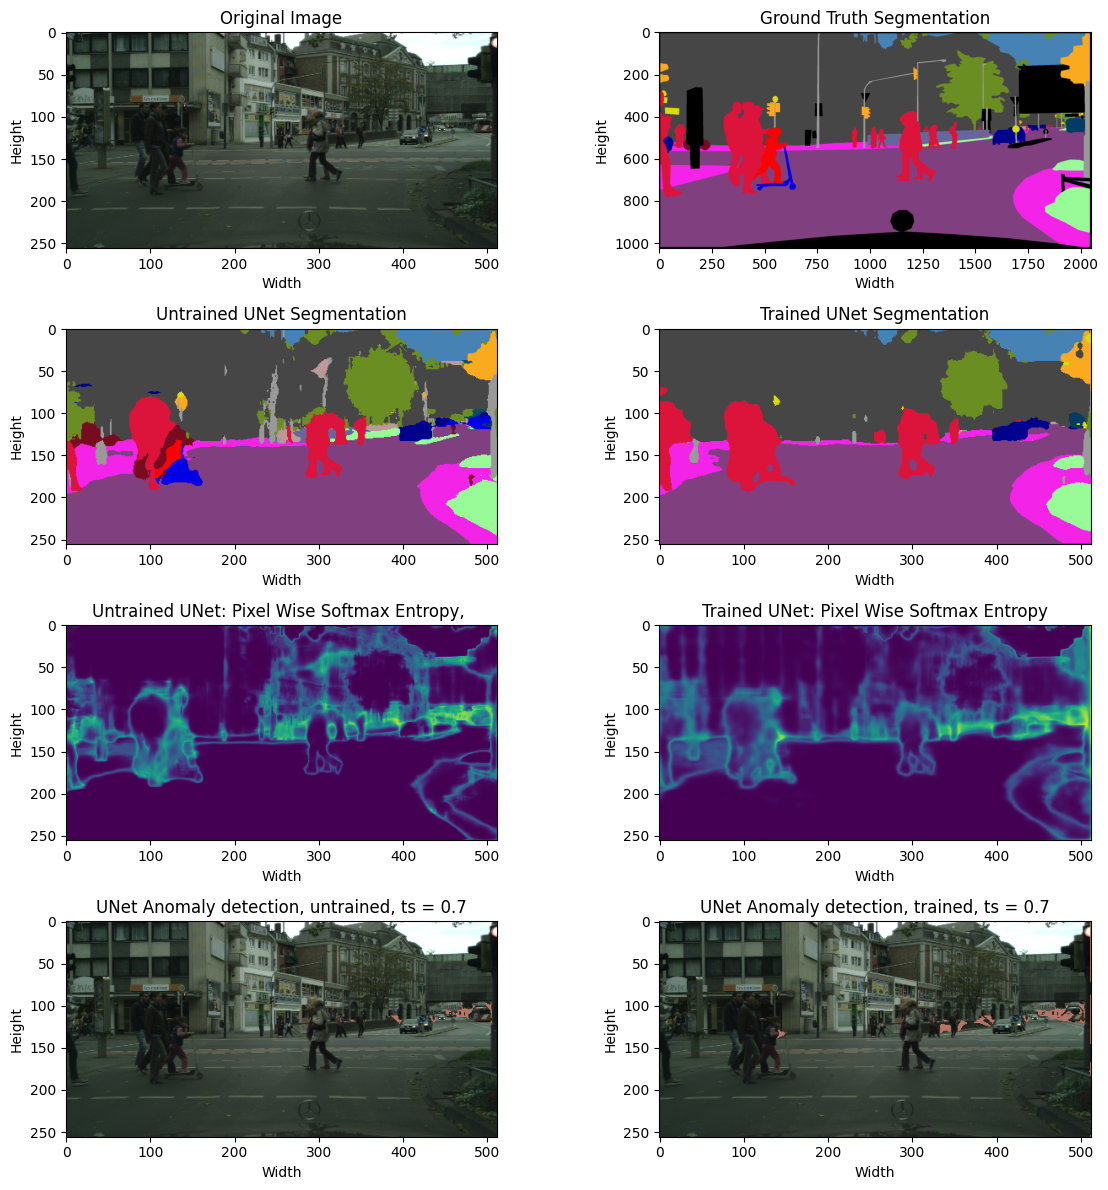

In [14]:
# 4) SUMMARY FOR UNET
index=14
image_plot=images_CS_UNet[index]
image_plot=image_plot.squeeze(0)
target=targets_CS[index].squeeze(0)
image = images_CS_UNet[index].clone()
with torch.no_grad():
    sem_pred_train = UNet_trained(image.cuda())
    sem_pred = UNet_untrained(image.cuda())
sem_pred_train = sem_pred_train.data.cpu()
sem_pred_train=torch.argmax(sem_pred_train[0], dim=0)
sem_pred_train=convert_trainid_to_color(sem_pred_train).numpy()

sem_pred = sem_pred.data.cpu()
sem_pred=torch.argmax(sem_pred[0], dim=0)
sem_pred=convert_trainid_to_color(sem_pred).numpy()
target=convert_trainid_to_color(target).numpy()

#2. Get pixel-wise Softmax Entropy
pixel_wise_softmax_entropy_train = prediction_softmax_entropy(UNet_trained, image)
pixel_wise_softmax_entropy_untrain = prediction_softmax_entropy(UNet_untrained, image)

#3. Plot Results
fig, axs = plt.subplots(4, 2, figsize=(12, 12))

im0 = axs[0,0].imshow(np.clip(np.transpose(image_plot.numpy(),(1,2,0))*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406]),0,1))
axs[0,0].set_title('Original Image')
axs[0,0].set_xlabel('Width')
axs[0,0].set_ylabel('Height')

im1 = axs[0,1].imshow(target, cmap='viridis')
axs[0,1].set_title('Ground Truth Segmentation')
axs[0,1].set_xlabel('Width')
axs[0,1].set_ylabel('Height')
# fig.colorbar(im1, ax=axs[0])

im2 = axs[1,0].imshow(sem_pred, cmap='viridis')
axs[1,0].set_title('Untrained UNet Segmentation')
axs[1,0].set_xlabel('Width')
axs[1,0].set_ylabel('Height')
# fig.colorbar(im1, ax=axs[0])

im3 = axs[1,1].imshow(sem_pred_train, cmap='viridis')
axs[1,1].set_title('Trained UNet Segmentation')
axs[1,1].set_xlabel('Width')
axs[1,1].set_ylabel('Height')
# fig.colorbar(im2, ax=axs[1])

im4 = axs[2,0].imshow(pixel_wise_softmax_entropy_untrain, cmap='viridis')
axs[2,0].set_title('Untrained UNet: Pixel Wise Softmax Entropy, ')
axs[2,0].set_xlabel('Width')
axs[2,0].set_ylabel('Height')
# fig.colorbar(im2, ax=axs[1])

im5 = axs[2,1].imshow(pixel_wise_softmax_entropy_train, cmap='viridis')
axs[2,1].set_title('Trained UNet: Pixel Wise Softmax Entropy')
axs[2,1].set_xlabel('Width')
axs[2,1].set_ylabel('Height')

threshold=0.7
image_untrained=detect_anomaly(UNet_untrained, image, threshold)
im6 = axs[3,0].imshow(np.clip(np.transpose(image_untrained.numpy(),(1,2,0))*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406]),0,1))
axs[3,0].set_title('UNet Anomaly detection, untrained, ts = {}'.format(threshold))
axs[3,0].set_xlabel('Width')
axs[3,0].set_ylabel('Height')

image_trained=detect_anomaly(UNet_trained, image, threshold)
im7 = axs[3,1].imshow(np.clip(np.transpose(image_trained.numpy(),(1,2,0))*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406]),0,1))
axs[3,1].set_title('UNet Anomaly detection, trained, ts = {}'.format(threshold))
axs[3,1].set_xlabel('Width')
axs[3,1].set_ylabel('Height')

plt.tight_layout()
plt.show()

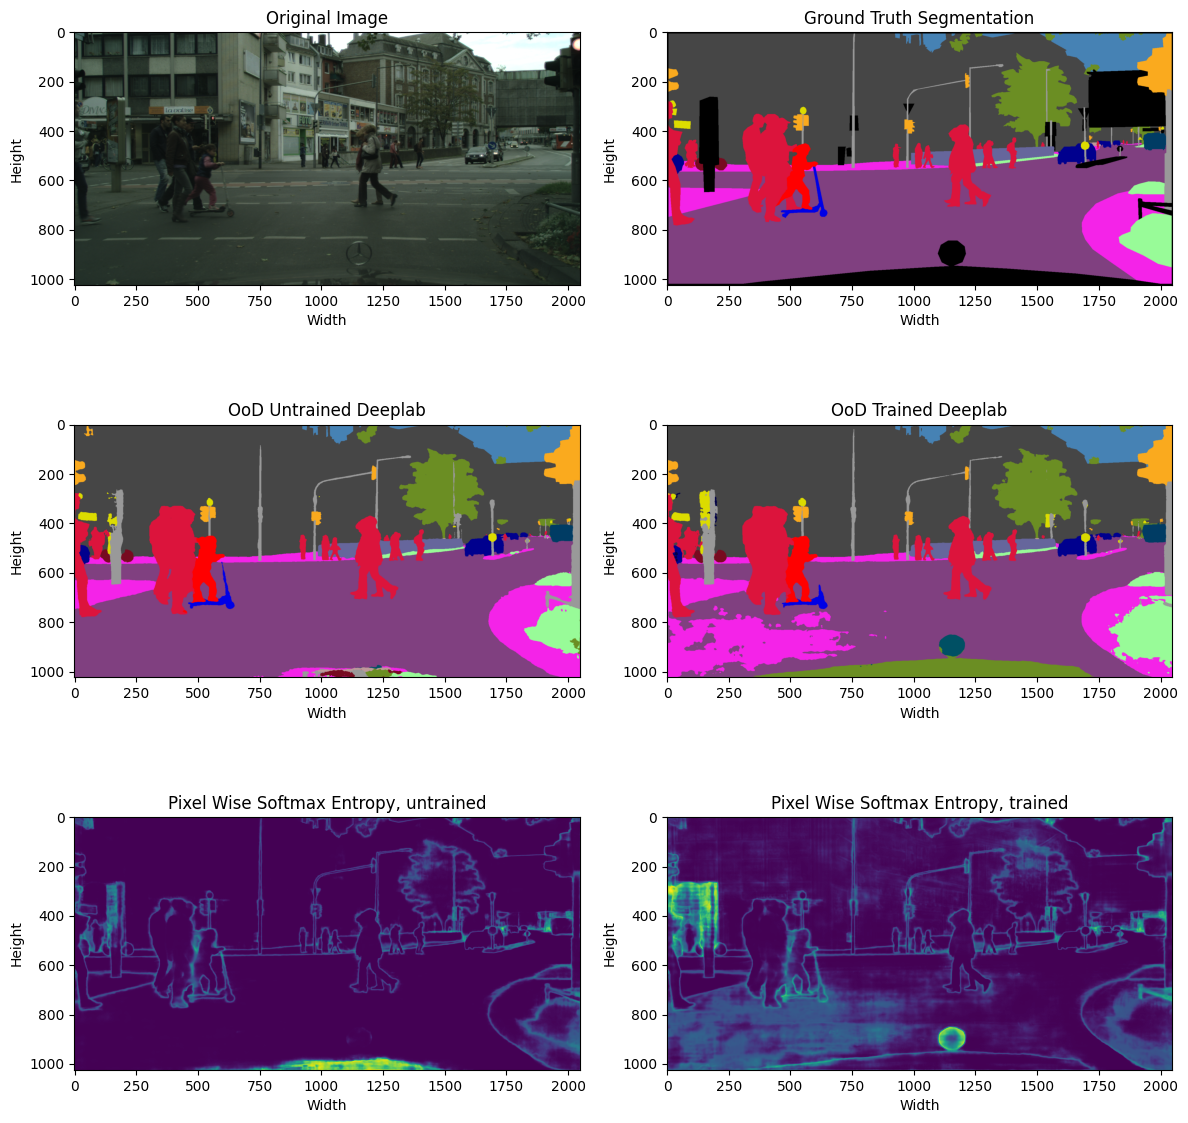

In [15]:
# 5) SUMMARY FOR Deeplab


# TODO: We need higher resolution here!
image_plot=images_CS_Deeplab[index]
image_plot=image_plot.squeeze(0)
target=targets_CS[index].squeeze(0)
image = images_CS_Deeplab[index].clone()
with torch.no_grad():
    sem_pred_train = Deeplab_trained(image.cuda())
    sem_pred = Deeplab_untrained(image.cuda())
sem_pred_train = sem_pred_train.data.cpu()
sem_pred_train=torch.argmax(sem_pred_train[0], dim=0)
sem_pred_train=convert_trainid_to_color(sem_pred_train).numpy()

sem_pred = sem_pred.data.cpu()
sem_pred=torch.argmax(sem_pred[0], dim=0)
sem_pred=convert_trainid_to_color(sem_pred).numpy()
target=convert_trainid_to_color(target).numpy()

#2. Get pixel-wise Softmax Entropy
pixel_wise_softmax_entropy_train = prediction_softmax_entropy(Deeplab_trained, image)
pixel_wise_softmax_entropy_untrain = prediction_softmax_entropy(Deeplab_untrained, image)

#3. Plot Results
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

im0 = axs[0,0].imshow(np.clip(np.transpose(image_plot.numpy(),(1,2,0))*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406]),0,1))
axs[0,0].set_title('Original Image')
axs[0,0].set_xlabel('Width')
axs[0,0].set_ylabel('Height')

im1 = axs[0,1].imshow(target, cmap='viridis')
axs[0,1].set_title('Ground Truth Segmentation')
axs[0,1].set_xlabel('Width')
axs[0,1].set_ylabel('Height')
# fig.colorbar(im1, ax=axs[0])

im2 = axs[1,0].imshow(sem_pred, cmap='viridis')
axs[1,0].set_title('OoD Untrained Deeplab')
axs[1,0].set_xlabel('Width')
axs[1,0].set_ylabel('Height')
# fig.colorbar(im1, ax=axs[0])

im3 = axs[1,1].imshow(sem_pred_train, cmap='viridis')
axs[1,1].set_title('OoD Trained Deeplab')
axs[1,1].set_xlabel('Width')
axs[1,1].set_ylabel('Height')
# fig.colorbar(im2, ax=axs[1])

im4 = axs[2,0].imshow(pixel_wise_softmax_entropy_untrain, cmap='viridis')
axs[2,0].set_title('Pixel Wise Softmax Entropy, untrained')
axs[2,0].set_xlabel('Width')
axs[2,0].set_ylabel('Height')
# fig.colorbar(im2, ax=axs[1])

im5 = axs[2,1].imshow(pixel_wise_softmax_entropy_train, cmap='viridis')
axs[2,1].set_title('Pixel Wise Softmax Entropy, trained')
axs[2,1].set_xlabel('Width')
axs[2,1].set_ylabel('Height')

plt.tight_layout()
plt.show()

In [16]:
# 6) LOAD FISHYSCAPES DATASET
import argparse
import time
import os
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
from meta_ood.meta_ood_master.config import config_evaluation_setup
from meta_ood.meta_ood_master.src.imageaugmentations import Compose, Normalize, ToTensor
from meta_ood.meta_ood_master.src.model_utils import probs_gt_load
from meta_ood.meta_ood_master.src.helper import metrics_dump, components_dump, concatenate_metrics, metrics_to_dataset, components_load
from meta_ood.meta_ood_master.src.model_utils import inference
from multiprocessing import Pool, cpu_count
from scipy.stats import entropy
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.linear_model import LogisticRegression

args={"VALSET": "Fishyscapes", #or LostAndFound
      "MODEL": "DeepLabV3+_WideResNet38",
      "val_epoch": 0,
      "pareto_alpha": 0.9,
      "entropy_threshold":0.7,
      "metaseg_prepare": True,
      "segment_search":False,
      "fp_removal": False}

config = config_evaluation_setup(args)

transform = Compose([ToTensor(), Normalize(config.dataset.mean, config.dataset.std)])
datloader = config.dataset(root=config.roots.eval_dataset_root, split="Static", transform=transform)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Operating on {}.".format(device))

Operating on cuda.


In [17]:
# 7) LOAD FISHYSCAPES IMAGES
i=0
images_FS_Deeplab=[]
images_FS_UNet=[]
targets_FS=[]
max_images=30
desired_size=(256,512)
for x, target in datloader:
    images_FS_Deeplab.append(x)
    image = F.interpolate(x.unsqueeze(0), size=desired_size, mode='bilinear', align_corners=False)
    images_FS_UNet.append(image)
    targets_FS.append(target)
    progress=(i+1)*100/max_images
    print(f'Progress: {progress:.2f}%', end='\r', flush=True)
    time.sleep(0.1)
    i+=1
    # print(type(x))
    # print(x.shape)
    # plot_img_sem(x.squeeze(0),target.squeeze(0),from_trainid=True)
    if i>=max_images:
        # print("\n")
        print("Loaded {} images and targets.".format(max_images))
        break

Loaded 30 images and targets.


In [18]:
# IMPORTANT FUNCTIONS
def detect_anomaly(net, image, threshold):
    image=image.squeeze(0)
    entropy_pred=prediction_softmax_entropy(net,image.unsqueeze(0))
    entropy_mask = torch.zeros_like(entropy_pred)
    entropy_mask[entropy_pred > threshold] = 1
    mask_bool = entropy_mask.bool()
    image[0, mask_bool] = 255.0/255.0
    image[1, mask_bool] = 0.0/255.0
    image[2, mask_bool] = 0.0/255.0
    return(image)

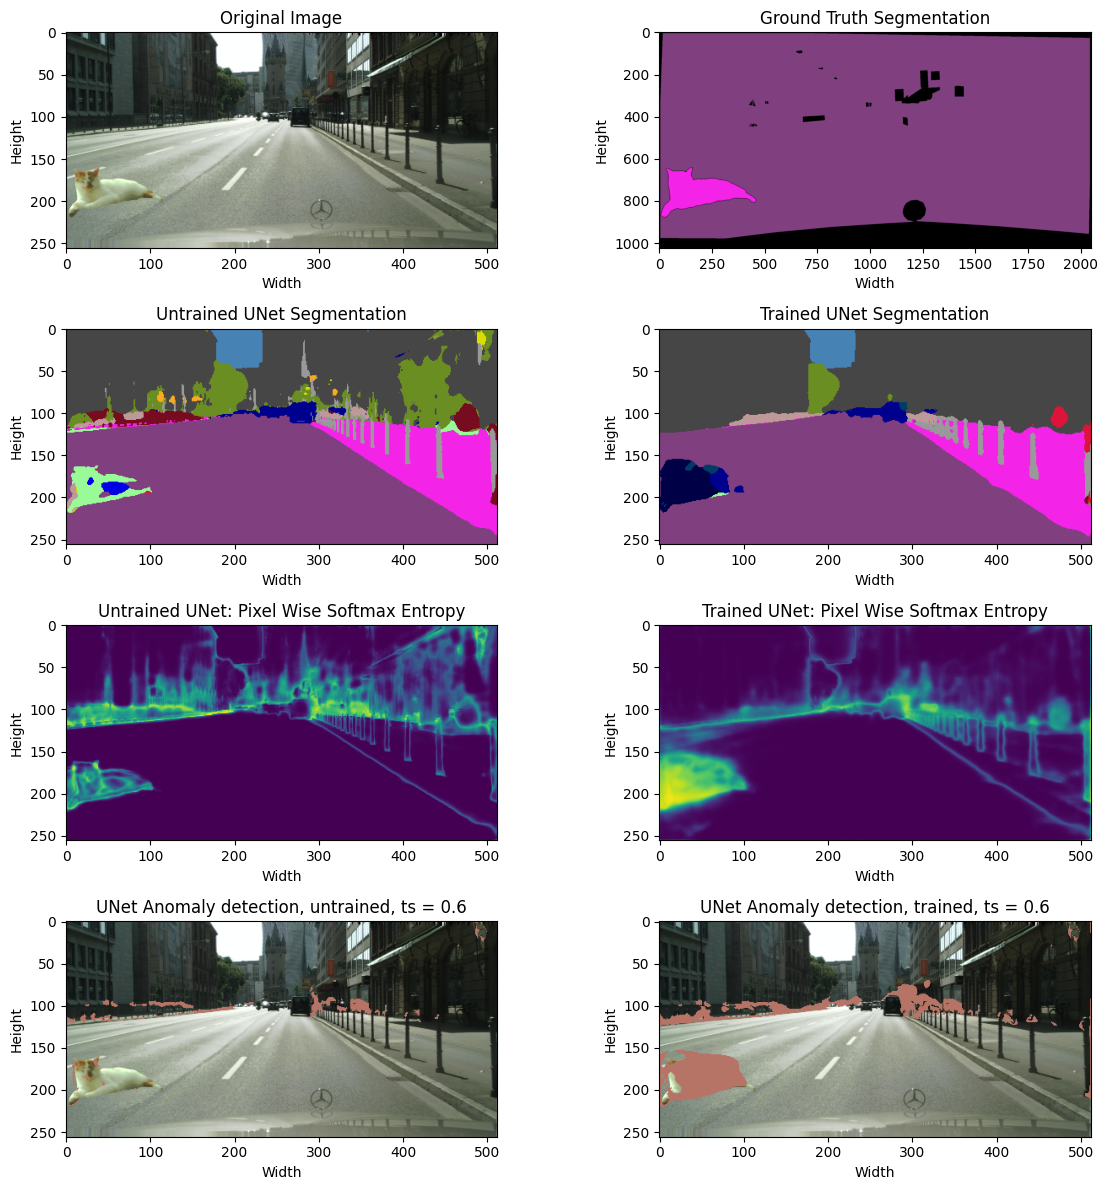

In [19]:
# 8) SUMMARY FOR UNet Fishyscapes
index=1
image_plot=images_FS_UNet[index].clone()
image_plot=image_plot.squeeze(0)
target=targets_FS[index].clone().squeeze(0)
image = images_FS_UNet[index].clone()
with torch.no_grad():
    sem_pred_train = UNet_trained(image.cuda())
    sem_pred = UNet_untrained(image.cuda())
sem_pred_train = sem_pred_train.data.cpu()
sem_pred_train=torch.argmax(sem_pred_train[0], dim=0)
sem_pred_train=convert_trainid_to_color(sem_pred_train).numpy()

sem_pred = sem_pred.data.cpu()
sem_pred=torch.argmax(sem_pred[0], dim=0)
sem_pred=convert_trainid_to_color(sem_pred).numpy()
target=convert_trainid_to_color(target).numpy()

#2. Get pixel-wise Softmax Entropy
pixel_wise_softmax_entropy_train = prediction_softmax_entropy(UNet_trained, image)
pixel_wise_softmax_entropy_untrain = prediction_softmax_entropy(UNet_untrained, image)

#3. Plot Results
fig, axs = plt.subplots(4, 2, figsize=(12, 12))

im0 = axs[0,0].imshow(np.clip(np.transpose(image_plot.numpy(),(1,2,0))*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406]),0,1))
axs[0,0].set_title('Original Image')
axs[0,0].set_xlabel('Width')
axs[0,0].set_ylabel('Height')

im1 = axs[0,1].imshow(target, cmap='viridis')
axs[0,1].set_title('Ground Truth Segmentation')
axs[0,1].set_xlabel('Width')
axs[0,1].set_ylabel('Height')
# fig.colorbar(im1, ax=axs[0])

im2 = axs[1,0].imshow(sem_pred, cmap='viridis')
axs[1,0].set_title('Untrained UNet Segmentation')
axs[1,0].set_xlabel('Width')
axs[1,0].set_ylabel('Height')
# fig.colorbar(im1, ax=axs[0])

im3 = axs[1,1].imshow(sem_pred_train, cmap='viridis')
axs[1,1].set_title('Trained UNet Segmentation')
axs[1,1].set_xlabel('Width')
axs[1,1].set_ylabel('Height')
# fig.colorbar(im2, ax=axs[1])

im4 = axs[2,0].imshow(pixel_wise_softmax_entropy_untrain, cmap='viridis')
axs[2,0].set_title('Untrained UNet: Pixel Wise Softmax Entropy')
axs[2,0].set_xlabel('Width')
axs[2,0].set_ylabel('Height')
# fig.colorbar(im2, ax=axs[1])

im5 = axs[2,1].imshow(pixel_wise_softmax_entropy_train, cmap='viridis')
axs[2,1].set_title('Trained UNet: Pixel Wise Softmax Entropy')
axs[2,1].set_xlabel('Width')
axs[2,1].set_ylabel('Height')

threshold=0.6
image_untrained=detect_anomaly(UNet_untrained, image, threshold)
im6 = axs[3,0].imshow(np.clip(np.transpose(image_untrained.numpy(),(1,2,0))*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406]),0,1))
axs[3,0].set_title('UNet Anomaly detection, untrained, ts = {}'.format(threshold))
axs[3,0].set_xlabel('Width')
axs[3,0].set_ylabel('Height')

image_trained=detect_anomaly(UNet_trained, image, threshold)
im7 = axs[3,1].imshow(np.clip(np.transpose(image_trained.numpy(),(1,2,0))*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406]),0,1))
axs[3,1].set_title('UNet Anomaly detection, trained, ts = {}'.format(threshold))
axs[3,1].set_xlabel('Width')
axs[3,1].set_ylabel('Height')

plt.tight_layout()
plt.show()



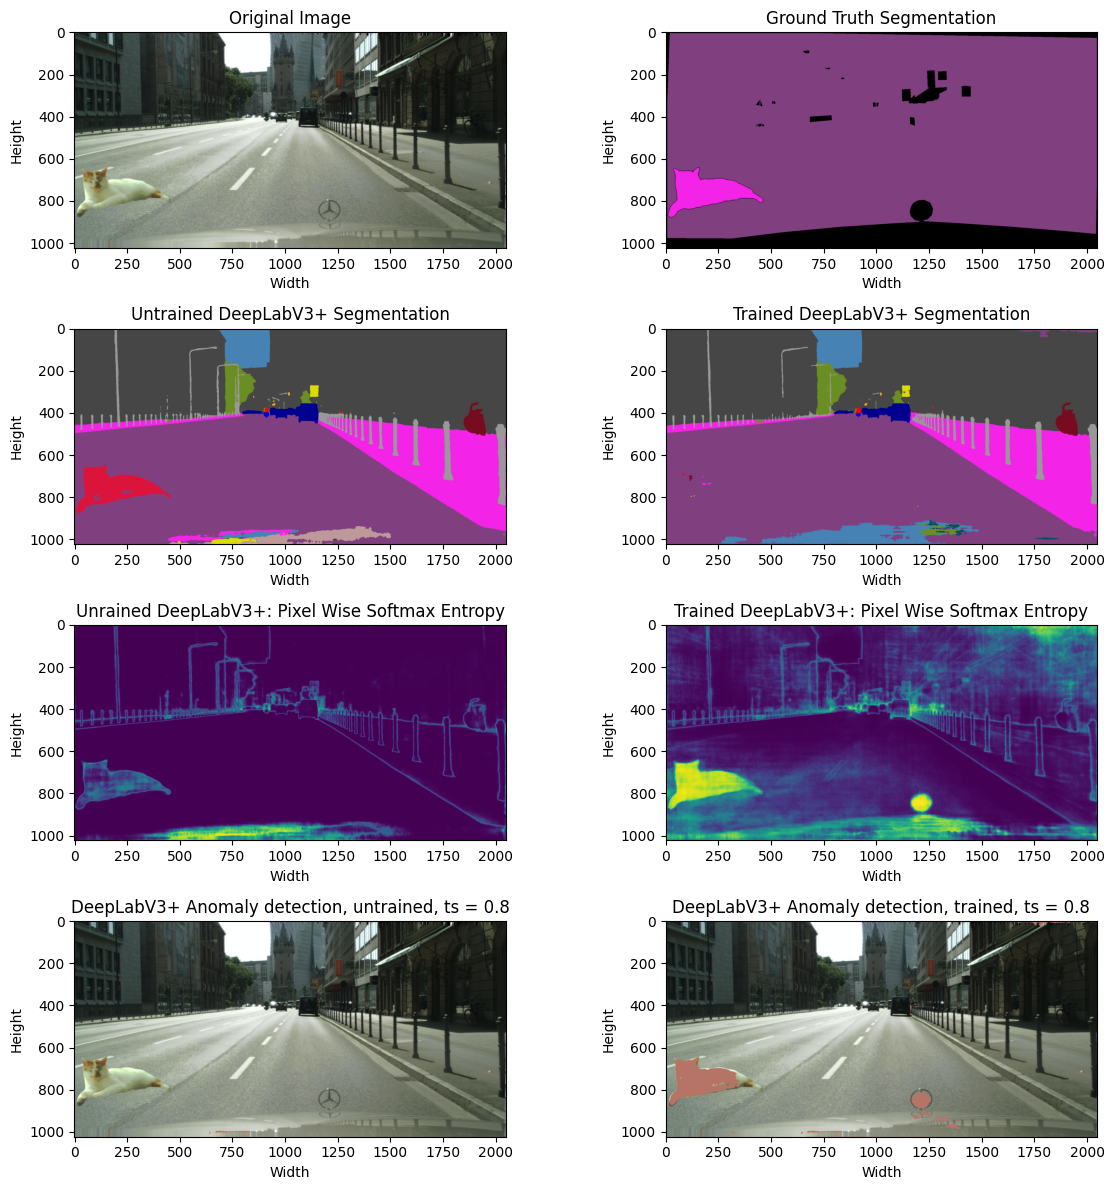

In [21]:
# 9) SUMMARY FOR Deeplab Fishyscapes

image_plot=images_FS_Deeplab[index].clone()
image_plot=image_plot.squeeze(0)
target=targets_FS[index].clone().squeeze(0)
image = images_FS_Deeplab[index].clone().unsqueeze(0)
with torch.no_grad():
    sem_pred_train = Deeplab_trained(image.cuda())
    sem_pred = Deeplab_untrained(image.cuda())
sem_pred_train = sem_pred_train.data.cpu()
sem_pred_train=torch.argmax(sem_pred_train[0], dim=0)
sem_pred_train=convert_trainid_to_color(sem_pred_train).numpy()

sem_pred = sem_pred.data.cpu()
sem_pred=torch.argmax(sem_pred[0], dim=0)
sem_pred=convert_trainid_to_color(sem_pred).numpy()
target=convert_trainid_to_color(target).numpy()

#2. Get pixel-wise Softmax Entropy
pixel_wise_softmax_entropy_train = prediction_softmax_entropy(Deeplab_trained, image)
pixel_wise_softmax_entropy_untrain = prediction_softmax_entropy(Deeplab_untrained, image)

#3. Plot Results
fig, axs = plt.subplots(4, 2, figsize=(12, 12))

im0 = axs[0,0].imshow(np.clip(np.transpose(image_plot.numpy(),(1,2,0))*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406]),0,1))
axs[0,0].set_title('Original Image')
axs[0,0].set_xlabel('Width')
axs[0,0].set_ylabel('Height')

im1 = axs[0,1].imshow(target, cmap='viridis')
axs[0,1].set_title('Ground Truth Segmentation')
axs[0,1].set_xlabel('Width')
axs[0,1].set_ylabel('Height')
# fig.colorbar(im1, ax=axs[0])

im2 = axs[1,0].imshow(sem_pred, cmap='viridis')
axs[1,0].set_title('Untrained DeepLabV3+ Segmentation')
axs[1,0].set_xlabel('Width')
axs[1,0].set_ylabel('Height')
# fig.colorbar(im1, ax=axs[0])

im3 = axs[1,1].imshow(sem_pred_train, cmap='viridis')
axs[1,1].set_title('Trained DeepLabV3+ Segmentation')
axs[1,1].set_xlabel('Width')
axs[1,1].set_ylabel('Height')
# fig.colorbar(im2, ax=axs[1])

im4 = axs[2,0].imshow(pixel_wise_softmax_entropy_untrain, cmap='viridis')
axs[2,0].set_title('Unrained DeepLabV3+: Pixel Wise Softmax Entropy')
axs[2,0].set_xlabel('Width')
axs[2,0].set_ylabel('Height')
# fig.colorbar(im2, ax=axs[1])

im5 = axs[2,1].imshow(pixel_wise_softmax_entropy_train, cmap='viridis')
axs[2,1].set_title('Trained DeepLabV3+: Pixel Wise Softmax Entropy')
axs[2,1].set_xlabel('Width')
axs[2,1].set_ylabel('Height')

threshold=0.8
image_untrained=detect_anomaly(Deeplab_untrained, image, threshold)
im6 = axs[3,0].imshow(np.clip(np.transpose(image_untrained.numpy(),(1,2,0))*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406]),0,1))
axs[3,0].set_title('DeepLabV3+ Anomaly detection, untrained, ts = {}'.format(threshold))
axs[3,0].set_xlabel('Width')
axs[3,0].set_ylabel('Height')

image_trained=detect_anomaly(Deeplab_trained, image, threshold)
im7 = axs[3,1].imshow(np.clip(np.transpose(image_trained.numpy(),(1,2,0))*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406]),0,1))
axs[3,1].set_title('DeepLabV3+ Anomaly detection, trained, ts = {}'.format(threshold))
axs[3,1].set_xlabel('Width')
axs[3,1].set_ylabel('Height')

plt.tight_layout()
plt.show()



In [34]:
from meta_ood.meta_ood_master.src.dataset.cityscapes_coco_mixed import CityscapesCocoMix
from meta_ood.meta_ood_master.config import config_training_setup
from meta_ood.meta_ood_master.src.imageaugmentations import Compose, Normalize, ToTensor, RandomCrop, RandomHorizontalFlip
from meta_ood.meta_ood_master.src.model_utils import load_network #, prediction
from torch.utils.data import DataLoader

args={"TRAINSET": "Cityscapes+COCO",
      "MODEL": "DeepLabV3+_WideResNet38",
      "training_starting_epoch": 0,
      "num_training_epochs": 3,
      "pareto_alpha": 0.9,
      "learning_rate": 1e-5,
      "crop_size": 480,
      "batch_size":1}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Operating on {}.".format(device))
config = config_training_setup(args)
params = config.params
roots = config.roots
dataset = config.dataset()
print("Pareto alpha:", params.pareto_alpha)
transform = Compose([ToTensor(), Normalize(dataset.mean, dataset.std)])#RandomHorizontalFlip(), RandomCrop(params.crop_size), 
trainloader = config.dataset('train', transform, roots.cs_root, roots.coco_root, params.ood_subsampling_factor)
dataloader = DataLoader(trainloader, batch_size=params.batch_size, shuffle=False)
class SegmentationRunningScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))
    # CONF MATRIX
    # 0 1 2 (PRED)
    # 0 |TP FN FN|
    # 1 |FP TP FN|
    # 2 |FP FP TP|
    # (GT)
    # -> rows (axis=1) are FN
    # -> columns (axis=0) are FP
    def iou(self):
        hist = self.confusion_matrix
        true_positives = np.diag(hist)
        false_positives=[]
        false_negatives=[]
        false_negative_sum=np.sum(hist,axis=1)
        false_positive_sum=np.sum(hist,axis=0)
        for i in range (self.n_classes):
            false_negatives.append(false_negative_sum[i]-hist[i,i])
        for i in range (self.n_classes):
            false_positives.append(false_positive_sum[i]-hist[i,i])
        class_iou = true_positives / (true_positives + false_positives +false_negatives)
        class_iou = np.nan_to_num(class_iou, nan=-1) # Convert NaN to -1
        valid_indices = np.where(class_iou >= 0)[0]
        valid_iou = class_iou[valid_indices]
        mean_iou = np.mean(valid_iou) if valid_iou.size > 0 else 0.0
        class_iou_dict = {trainid: iou for trainid, iou in zip(valid_indices,valid_iou)}
        return class_iou_dict, mean_iou
    def fast_hist(self, label_true, label_pred):
        mask=(label_true>=0)&(label_true<self.n_classes)
        hist=np.bincount(
        self.n_classes*label_true[mask].astype(int)+label_pred[mask],minlength=self.n_classes**2,
        ).reshape(self.n_classes, self.n_classes)
        return hist
    def update(self, label_trues, label_preds):
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            self.confusion_matrix += self.fast_hist(label_trues.flatten(),label_preds.flatten())
        
    def get_scores(self):
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            iou, meaniou = self.iou()
        return iou, meaniou
    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))
def val(model):
    torch.manual_seed(88395)
    dataset_val = config.dataset()
    dataloader_val = DataLoader(trainloader, batch_size=params.batch_size, shuffle=False)
    score=SegmentationRunningScore(19)
    batch_count=0
    for batch in dataloader_val:
        inputs, labels = batch[0], batch[1]
        outputs=model(inputs.cuda())
        _,predicted=torch.max(outputs,1)
        predicted=predicted.cpu().numpy()
        labels=convert_id_to_trainid(labels)
        score.update(labels.numpy(), predicted)
        batch_count+=1
        if batch_count==3:
            break
    iou, mean_iou=score.get_scores()
    return iou, mean_iou


Operating on cuda.
Pareto alpha: 0.9


In [ ]:
# 1) LOAD TRAINED AND UNTRAINED DEEPLAB




In [37]:
checkpoint_path_trained="/work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_DeepLabV3+_WideResNet38/weights/DeepLabV3+_WideResNet38_epoch_3_alpha_0.9.pth"
checkpoint_path_untrained="/work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_DeepLabV3+_WideResNet38/weights/DeepLabV3+_WideResNet38.pth"

Deeplab_trained=load_network("DeepLabV3+_WideResNet38",19,checkpoint_path_trained)
Deeplab_untrained=load_network("DeepLabV3+_WideResNet38",19,checkpoint_path_untrained)    

# state_dict_trained=torch.load(checkpoint_path_trained)
# Deeplab_trained.load_state_dict(state_dict_trained['state_dict'])

# state_dict_untrained=torch.load(checkpoint_path_untrained)
# Deeplab_untrained.load_state_dict(state_dict_untrained['state_dict'])

iou_tr, meaniou_tr = val(Deeplab_trained)
iou_untr, meaniou_untr = val(Deeplab_untrained)

print("Mean IoU trained = {}".format(meaniou_tr))
print("Mean IoU untrained = {}".format(meaniou_untr))


Checkpoint file: /work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_DeepLabV3+_WideResNet38/weights/DeepLabV3+_WideResNet38_epoch_3_alpha_0.9.pth
Load model: DeepLabV3+_WideResNet38

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 44.38 GiB of which 2.38 MiB is free. Process 3062250 has 1.54 GiB memory in use. Process 3062561 has 1.80 GiB memory in use. Including non-PyTorch memory, this process has 5.80 GiB memory in use. Process 3062124 has 35.24 GiB memory in use. Of the allocated memory 4.41 GiB is allocated by PyTorch, and 43.23 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [104]:
# index=1
# image=images[index].clone()
# print(type(image))
# print(image.shape)
# image=image.squeeze(0)
# target=targets[index].clone().squeeze(0)
# plot_img_sem(image,target,from_trainid=True)
# image=image.unsqueeze(0)

In [105]:
# pred=prediction(Deeplab_untrained,image)
# sem_pred=torch.argmax(pred[0], dim=0)
# plot_img_sem(image.squeeze(0),sem_pred,from_trainid=True, save=True, name='Cat_segmented',index=0)

In [106]:
# softmax_pred=prediction_softmax(Deeplab_untrained,image)
# plt.imshow(softmax_pred, cmap='viridis')  # You can choose a different colormap
# plt.colorbar()
# plt.axis('off')
# plt.title('Maximum Softmax Values')
# plt.savefig('segmented_pictures/softmax_plot.png')
# plt.show()

In [107]:
# threshold = 0.3 #How certain do you have to be?
# softmax_mask = torch.zeros_like(softmax_pred)
# softmax_mask[softmax_pred < threshold] = 1
# cmap = plt.cm.colors.ListedColormap(['black', 'blue'])

# plt.imshow(softmax_mask, cmap=cmap)  # You can choose a different colormap
# plt.axis('off')
# plt.title('Maximum Softmax Values')
# plt.savefig('segmented_pictures/softmax_plot.png')
# plt.show()
# plt.close()


In [108]:
# mask_bool = softmax_mask.bool()
# image=image.squeeze(0)
# image[0, mask_bool] = 255.0/255.0
# image[1, mask_bool] = 0.0/255.0
# image[2, mask_bool] = 0.0# Assuming the green and blue channels are at indices 1 and 2
# plt.imshow(np.clip(np.transpose(image.numpy(),(1,2,0))*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406]),0,1))
# plt.show()




In [109]:
# for threshold in np.arange(0, 1.1, 0.1):
#     image=images[index].clone()
#     print(image.shape)
#     print(threshold)
#     softmax_pred=prediction_softmax(Model_untrained,image.unsqueeze(0))
#     softmax_mask = torch.zeros_like(softmax_pred)
#     softmax_mask[softmax_pred < threshold] = 1
#     mask_bool = softmax_mask.bool()
#     image[0, mask_bool] = 255.0/255.0
#     image[1, mask_bool] = 0.0/255.0
#     image[2, mask_bool] = 0.0/255.0
#     plt.imshow(np.clip(np.transpose(image.numpy(),(1,2,0))*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406]),0,1))
#     plt.tight_layout()
#     plt.axis('off')
#     plt.savefig("segmented_pictures/"+str(threshold)+".png",bbox_inches='tight', pad_inches=0.0)
#     plt.show()
#     plt.close()

In [135]:
# image=images[index].clone()
# sm_entropy=prediction_softmax_entropy(Model_untrained, image.unsqueeze(0))

In [110]:
# plt.imshow(sm_entropy, cmap='viridis')  # You can choose a different colormap
# # plt.colorbar()
# plt.tight_layout()
# plt.axis('off')
# # plt.title('Softmax Entropy')
# plt.savefig('segmented_pictures/softmax_entropy_plot.png',bbox_inches='tight', pad_inches=0.0)
# plt.show()

In [136]:
# # for threshold in np.arange(0, 1.1, 0.1):
# threshold=0.2
# image=images[index].clone()
# print(image.shape)
# print(threshold)
# entropy_pred=prediction_softmax_entropy(Deeplab_untrained,image)
# print(image.shape)
# entropy_mask = torch.zeros_like(entropy_pred)
# entropy_mask[entropy_pred > threshold] = 1
# mask_bool = entropy_mask.bool()
# image.squeeze(0)[0, mask_bool] = 255.0/255.0
# image.squeeze(0)[1, mask_bool] = 0.0/255.0
# image.squeeze(0)[2, mask_bool] = 0.0/255.0
# image=image.squeeze(0)
# plt.imshow(np.clip(np.transpose(image.numpy(),(1,2,0))*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406]),0,1))
# plt.tight_layout()
# plt.axis('off')
# plt.savefig("segmented_pictures/entropy"+str(threshold)+".png",bbox_inches='tight', pad_inches=0.0)
# plt.show()
# plt.close()

In [137]:
# image=images[index].clone()
# sm_entropy=prediction_softmax_entropy(Deeplab_trained, image)
# print(sm_entropy.shape)

In [138]:
# plt.imshow(sm_entropy, cmap='viridis')  # You can choose a different colormap
# # plt.colorbar()
# plt.tight_layout()
# plt.axis('off')
# # plt.title('Softmax Entropy')
# plt.savefig('segmented_pictures/softmax_entropy_plot_trained.png',bbox_inches='tight', pad_inches=0.0)
# plt.show()

In [10]:
# Resize images and create list of file paths
directory_path="/home/said_harb_uri_edu/own_pics/Static"
path=[]
file_paths=[]
for root, dirs, files in os.walk(directory_path):
    for file in files:
        path=os.path.join(root,file)
        file_paths.append(os.path.join(root,file))
        image = Image.open(path)
        resized_image = image.resize((2048, 1024))
        resized_image.save("/home/said_harb_uri_edu/own_pics/Static/{}".format(file))

In [11]:
#Filter file paths for checkpoint files
contains_checkpoint = any("checkpoint" in s for s in file_paths)
if contains_checkpoint:
    file_paths = [s for s in file_paths if "checkpoint" not in s]

In [12]:
#Transform to Tensor
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
tensor_image=[]
for file_path in file_paths:
    image = Image.open(file_path)
    transform = transforms.Compose([transforms.ToTensor(),])
    tensor_image.append(transform(image))


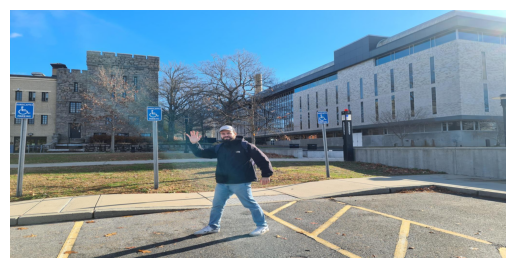

In [13]:
index=6
image=tensor_image[index].clone()
plt.imshow(image.permute(1, 2, 0))  # Transpose dimensions for display
plt.axis('off')
plt.show()

In [14]:

    
pred=prediction(Model_untrained,image.unsqueeze(0))

In [15]:
pred=torch.argmax(pred[0], dim=0)
print(pred.shape)

torch.Size([1024, 2048])


In [16]:
pred=convert_trainid_to_color(pred)

<class 'torch.Tensor'>


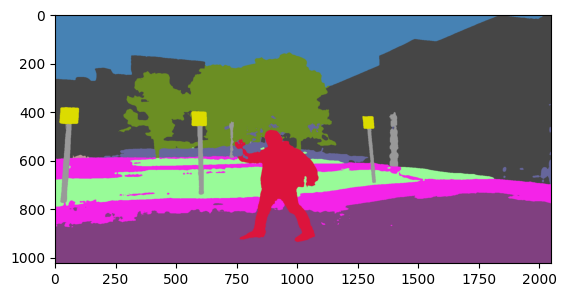

In [17]:
print(type(pred))
plt.imshow(pred)

In [18]:
pred_entropy=prediction_softmax_entropy(Model_trained,image.unsqueeze(0))

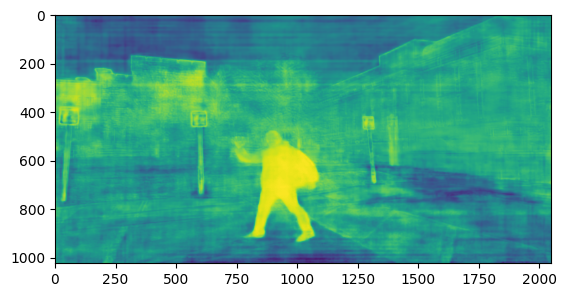

In [19]:
plt.imshow(pred_entropy)

torch.Size([3, 1024, 2048])
0.9


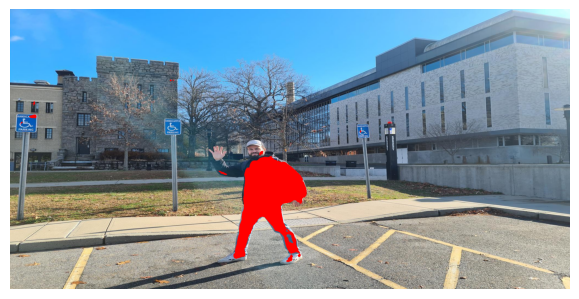

In [22]:
threshold=0.9
image=tensor_image[index].clone()
print(image.shape)
print(threshold)
entropy_pred=prediction_softmax_entropy(Model_trained,image.unsqueeze(0))
entropy_mask = torch.zeros_like(entropy_pred)
entropy_mask[entropy_pred > threshold] = 1
mask_bool = entropy_mask.bool()
image[0, mask_bool] = 255.0/255.0
image[1, mask_bool] = 0.0/255.0
image[2, mask_bool] = 0.0/255.0
plt.imshow(np.clip(np.transpose(image.numpy(),(1,2,0)),0,1))
plt.tight_layout()
plt.axis('off')
# plt.savefig("segmented_pictures/entropy_trained"+str(threshold)+".png",bbox_inches='tight', pad_inches=0.0)
plt.show()
plt.close()

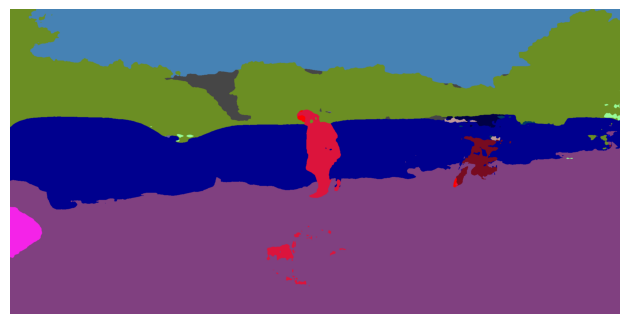

In [23]:
for index in range (0, len(file_paths)):
    image=tensor_image[index].clone()
    pred=prediction(Model_untrained,image.unsqueeze(0))
    pred=torch.argmax(pred[0], dim=0)
    pred=convert_trainid_to_color(pred)
    plt.tight_layout()
    plt.imshow(pred)
    plt.axis('off')
    plt.savefig("/home/said_harb_uri_edu/segmented_pictures/own_pic{}.png".format(index),bbox_inches='tight', pad_inches=0.0)


In [ ]:
for index in range (0, len(file_paths)):

    threshold=0.9
    image=tensor_image[index].clone()
    entropy_pred=prediction_softmax_entropy(Model_trained,image.unsqueeze(0))
    entropy_mask = torch.zeros_like(entropy_pred)
    entropy_mask[entropy_pred > threshold] = 1
    mask_bool = entropy_mask.bool()
    image[0, mask_bool] = 255.0/255.0
    image[1, mask_bool] = 0.0/255.0
    image[2, mask_bool] = 0.0/255.0
    plt.imshow(np.clip(np.transpose(image.numpy(),(1,2,0)),0,1))
    plt.tight_layout()
    plt.axis('off')
    plt.savefig("/home/said_harb_uri_edu/segmented_pictures/own_pic_entropy{}.png".format(index),bbox_inches='tight', pad_inches=0.0)